In [1]:
"""
EATING DISORDERS MONTECATINI

Purpose: pp check for HDDMrl model.

(1) diag_cat (diagnostic category) 

- AN     anorexia, 
- BN     bulimia, 
- HC     university students not at risk according to the EAT-26,
- RI     university students at risk according to the EAT-26, recovered bulimics, recovered anorexics.

(2) stim (stimulus)

- food and neutral images,
- two neutral images.

Some participants have been removed so as to avoind problems with the Gelman-Rubin index.
All excluded participants belong to the HC group, apart from al_ro_1989_04_25_160_f, who is AN.
There are 296 participants.

I removed 6 participants from the RI group:

to_be_deleted = [
"lu_mu_1997_03_18_059_f",
"de_sc_1992_07_02_116_f",
"fr_ro_1982_08_15_048_f",
"el_li_1999_09_08_687_f",
"ma_pi_2001_05_11_566_f",
"sa_sa_2000_11_24_418_m"
]


Written by Corrado Caudek (2023-01-28)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-02-15 12:22:16


In [138]:
# Import modules

# warning settings
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import arviz as az
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

The hddm version is 0.9.7


In [139]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) 
data = hddm.load_csv(
    "/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/hddm_input_v3.csv"
)

to_be_deleted = [
    "lu_mu_1997_03_18_059_f",
    "de_sc_1992_07_02_116_f",
    "fr_ro_1982_08_15_048_f",
    "el_li_1999_09_08_687_f",
    "ma_pi_2001_05_11_566_f",
    "sa_sa_2000_11_24_418_m"
]

df = data.query("subj_code not in @to_be_deleted")
print("There are %d participants" % df["subj_idx"].nunique())

There are 296 participants


In [140]:
dicat_mapping = {
    "AN": "AN",
    "AN_R": "RI",
    "BN": "BN",
    "BN_R": "RI",
    "HC": "HC",
    "RI": "RI",
}
df = df.assign(diag_cat=df["diag_cat"].map(dicat_mapping))
df["diag_cat"].value_counts()

HC    62080
AN    11040
RI    10240
BN     3520
Name: diag_cat, dtype: int64

In [141]:
df["subj_idx"] = pd.factorize(df["subj_code"])[0] + 1
df["subj_idx"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [142]:
df.columns

Index(['subj_idx', 'response', 'stim', 'rt', 'trial', 'split_by', 'feedback',
       'diag_cat', 'subj_code', 'q_init'],
      dtype='object')

## Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).

Let us consider only the AN patients in the food condition.

In [143]:
an_df = df.loc[(df["diag_cat"] == "AN")]
an_df.shape


(11040, 10)

Subjects that did not complete both food and neutral conditions must be removed.

In [144]:
to_be_removed = [
    "be_ma_1999_06_15_475_f",
    "ch_br_1993_10_04_623_f",
    "ch_pi_2001_10_08_418_f",
    "cr_pa_1969_04_12_179_f",
    "ma_va_1998_07_04_538_f",
]

anx_df = an_df.query("subj_code not in @to_be_removed")
print("There are %d participants" % anx_df["subj_code"].nunique())

There are 32 participants


In [145]:
anx_df["subj_idx"] = pd.factorize(anx_df["subj_code"])[0] + 1
anx_df["subj_idx"].unique()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_58900/305525794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anx_df["subj_idx"] = pd.factorize(anx_df["subj_code"])[0] + 1


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [112]:
summary_stats = (
    anx_df.loc[:, ["subj_code", "stim", "rt"]]
    .groupby(["subj_code", "stim"])
    .aggregate(["count"])
)
summary_stats.to_csv("fuck.csv")

In [147]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        anx_df,
        # bias=True,
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True,
    )
    m.sample(1000, burn=500, dbname="traces.db", db="pickle")
    models.append(m)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1001 of 1000 complete in 167.0 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1001 of 1000 complete in 174.9 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1000 of 1000 complete in 164.8 sec

In [148]:
m = kabuki.utils.concat_models(models)

In [149]:
m.print_stats()

                       mean       std       2.5q        25q       50q       75q      97.5q    mc err
a                  1.363201  0.039779   1.287374   1.334374  1.362063  1.388494   1.449821  0.001119
a_std              0.228292  0.033219   0.174253   0.203798   0.22528  0.248276   0.301963  0.001124
a_subj.1           1.192531  0.038001   1.119334     1.1664  1.192012  1.218304   1.267191  0.001594
a_subj.2           1.273868     0.035   1.205148   1.249773  1.274465  1.297706   1.341913  0.001368
a_subj.3           1.498899  0.042696   1.417163   1.470447  1.496757  1.527359     1.5832  0.001677
a_subj.4           1.189607  0.034105   1.124458   1.165283  1.189625  1.212912   1.255944  0.001387
a_subj.5            1.73762  0.049394   1.645215   1.702825  1.735125  1.772519   1.837777  0.001674
a_subj.6           1.414123  0.042623   1.335042   1.383884  1.413394  1.441572   1.498872  0.001655
a_subj.7           1.494036  0.039955   1.419334   1.465665  1.491858  1.519942   1.577395 

Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate 
- pos_alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.

In [150]:
# Combine the models
traces = m.get_traces()
traces.head()

,a,a_std,a_subj.1,a_subj.2,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.7,a_subj.8,...,pos_alpha_subj.23,pos_alpha_subj.24,pos_alpha_subj.25,pos_alpha_subj.26,pos_alpha_subj.27,pos_alpha_subj.28,pos_alpha_subj.29,pos_alpha_subj.30,pos_alpha_subj.31,pos_alpha_subj.32
0,1.306444,0.280423,1.207245,1.266148,1.581456,1.167499,1.782592,1.404481,1.492854,0.889634,...,-3.979438,-9.633265,-0.843728,0.117014,4.704462,-6.022257,-0.224298,-2.318422,-6.688502,6.569293
1,1.350204,0.270769,1.211452,1.330555,1.516892,1.217253,1.691837,1.418202,1.457610,0.900339,...,-4.022365,-7.496945,-0.753448,0.305250,1.861734,-2.561311,-0.296573,-2.881768,-4.259512,9.314373
2,1.435889,0.349206,1.157802,1.309878,1.493744,1.225222,1.717239,1.403281,1.542963,0.921871,...,-4.389521,-7.781320,-0.658112,0.616722,8.331656,-4.093601,0.033866,-3.132484,5.423637,2.871564
3,1.421333,0.286392,1.191053,1.308987,1.518077,1.224277,1.718691,1.428701,1.581075,0.903542,...,6.354826,-7.450189,-1.080166,0.022656,8.675754,-2.995884,-0.064050,-4.897957,-1.666375,1.402778
4,1.363757,0.290378,1.223140,1.273928,1.580958,1.226325,1.753215,1.417227,1.627945,0.888770,...,-6.378714,-8.761993,-0.491484,0.312555,6.476723,-1.418035,0.101069,-1.064038,-3.478932,7.220615


In [151]:
df1 = hddm.generate.gen_rand_rlddm_data(
    a=1.36,
    t=0.17,
    alpha=1.77,
    pos_alpha=0.55,
    scaler=1.28,
    p_upper=0.7,
    p_lower=0.3,
    subjs=32,
    split_by=0,
    size=80,
)

In [152]:
df1.head()


,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial
0,0.500000,0.5,0.000000,0.0,0.360682,0.0,0,0,1
1,0.500000,0.0,0.827665,1.0,0.588682,1.0,0,0,2
2,0.757849,0.0,1.254490,1.0,0.348682,1.0,0,0,3
3,0.882726,0.0,1.461203,1.0,0.701682,1.0,0,0,4
4,0.943204,0.0,1.561314,1.0,0.331682,0.0,0,0,5


In [153]:
data = anx_df

In [154]:
from tqdm import tqdm  # progress tracker

# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
data["samp"] = 0
# load traces
traces = m.get_traces()

# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 6)): # 51
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0] - 1)
    # loop through all subjects in observed data
    for s in data.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 0)].trial.unique()
        )
        size1 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 1)].trial.unique()
        )
        # set parameter values for simulation
        a = traces.loc[sample, "a_subj." + str(s)]
        t = traces.loc[sample, "t_subj." + str(s)]
        scaler = traces.loc[sample, "v_subj." + str(s)]
        alphaInv = traces.loc[sample, "alpha_subj." + str(s)]
        # take inverse logit of estimated alpha
        alpha = np.exp(alphaInv) / (1 + np.exp(alphaInv))
        # simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data( 
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            size=size0,
            p_upper=0.7,
            p_lower=0.3,
            split_by=0, # FOOD
        )
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            size=size1,
            p_upper=0.7,
            p_lower=0.3,
            split_by=1, # NEUTRAL
        )
        # append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # assign subj_idx
        sim_data0["subj_idx"] = s
        # identify that these are simulated data
        sim_data0["type"] = "simulated"
        # identify the simulated data
        sim_data0["samp"] = i
        # append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)
# combine observed and simulated data
ppc_data = data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "samp"]
].copy()
ppc_data["type"] = "observed"
ppc_sdata = sim_data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "type", "samp"]
].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv("ppc_data_tutorial.csv")


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_58900/4034796952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["samp"] = 0
100%|██████████| 20/20 [15:37<00:00, 46.87s/it]


In [158]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()
plot_ppc_data = ppc_data.copy()

In [159]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data["bin_trial"] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim["upper_hpd"] = 0
ppc_sim["lower_hpd"] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_sim.bin_trial[i])
            & (sums["split_by"] == ppc_sim.split_by[i])
            & (sums["type"] == ppc_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim["up_err"] = ppc_sim["upper_hpd"] - ppc_sim["response"]
ppc_sim["low_err"] = ppc_sim["response"] - ppc_sim["lower_hpd"]
ppc_sim["model"] = "RLDDM_single_learning"
ppc_sim.to_csv("ppc_choicedata_tutorial.csv")

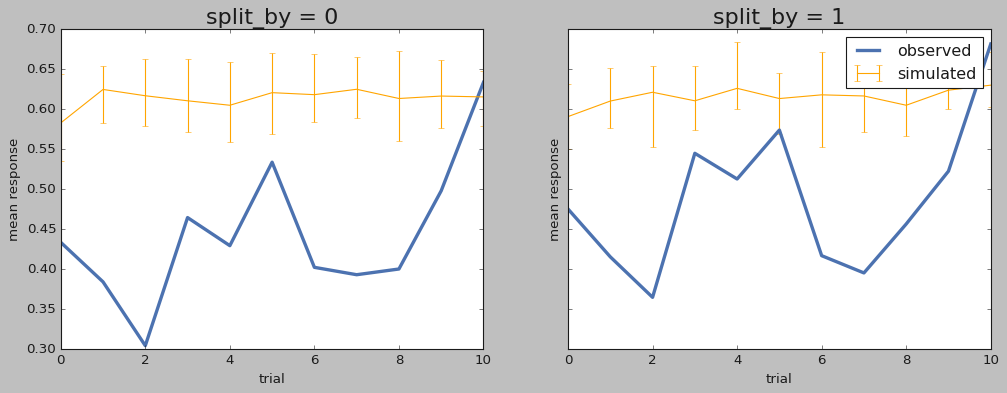

In [160]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "simulated")]
    ax.errorbar(
        d.bin_trial,
        d.response,
        yerr=[d.low_err, d.up_err],
        label="simulated",
        color="orange",
    )
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "observed")]
    ax.plot(d.bin_trial, d.response, linewidth=3, label="observed")
    ax.set_title("split_by = %i" % i, fontsize=20)
    ax.set_ylabel("mean response")
    ax.set_xlabel("trial")
plt.legend()
fig.savefig("PPCchoice.pdf")